# 语义分割筛选街景照片
[Part3.获取高质量的阿姆斯特丹建筑立面图像（下）——《通过深度学习了解建筑年代和风格》](https://cdn.renhai-lab.tech/archives/Understanding_architecture_age_and_style_through_deep_learning_part3-2)

模型来源semantic-segmentation-pytorch，仓库地址
https://github.com/CSAILVision/semantic-segmentation-pytorch/

colab测试地址 https://colab.research.google.com/github/CSAILVision/semantic-segmentation-pytorch/blob/master/notebooks/DemoSegmenter.ipynb

## 测试环境
运行demo_test.sh

## 导入库
我们需要pytorch、numpy和分割模型的代码。以及一些可视化数据的实用程序。

In [ ]:
# 导入库
import PIL.Image
import csv
import numpy as np
import os
import scipy.io
import torch
import torchvision.transforms
from IPython.display import display

In [ ]:
# 导入仓库定义的库 从github地址下载 或者安装 pip install git+https://github.com/CSAILVision/semantic-segmentation-pytorch.git@master
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

In [ ]:
seg_repo_dir = "./semantic-segmentation-pytorch-master"

# 加载颜色映射表
colors = scipy.io.loadmat(f'{seg_repo_dir}/data/color150.mat')['colors']

# 加载类别名称映射表
names = {}
with open(f'{seg_repo_dir}/data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader) # 跳过标题行
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0] # 以分号分割，取第一个

def visualize_result(img, pred, index=None):
    # 如果指定了类别索引，过滤预测结果
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1 # 把不是index的都变成-1
        print(f'{names[index+1]}:') # 打印类别名称

    # 为预测结果上色
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # 合并图像并保存
    im_vis = numpy.concatenate((img, pred_color), axis=1) # 将原始图像和彩色编码的分割结果并排放置
    display(PIL.Image.fromarray(im_vis))
    return pred_color


## 加载分段模型

在这里，我们加载一个预训练的分割模型。 像任何 pytorch 模型一样，我们可以像函数一样调用它，或者检查所有层中的参数。

加载后，我们将其放在 GPU 上。 由于我们是在进行推理，而不是训练，因此我们将模型置于评估模式。

In [ ]:
# 网络构建器
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights=f'{seg_repo_dir}/ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth') 
    # 使用预训练的resnet50dilated模型构建编码器，设置全连接层维度为2048，加载权重文件路径为...
    # 权重文件可以从 http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/ 获取

net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights=f'{seg_repo_dir}/ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)
    # 使用ppm_deepsup模型构建解码器，设置全连接层维度为2048，类别数为150，加载权重文件路径为...，使用softmax激活函数

crit = torch.nn.NLLLoss(ignore_index=-1)
    # 定义损失函数为负对数似然损失，忽略索引为-1的部分

segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
    # 构建语义分割模块，传入编码器、解码器和损失函数

segmentation_module.eval()
    # 将语义分割模块设置为评估模式，不进行梯度计算

segmentation_module.cuda()
    # 将语义分割模块移动到GPU上进行计算，使用CUDA加速


## Load test data

Now we load and normalize a single test image.  Here we use the commonplace convention of normalizing the image to a scale for which the RGB values of a large photo dataset would have zero mean and unit standard deviation.  (These numbers come from the imagenet dataset.)  With this normalization, the limiiting ranges of RGB values are within about (-2.2 to +2.7).
现在我们加载并对一张测试图像进行归一化处理。在这里，我们使用常见的惯例，将图像归一化到一个尺度，使得大型照片数据集的RGB值具有零均值和单位标准差。（这些数值来自于ImageNet数据集。）通过这种归一化，RGB值的取值范围大约在（-2.2到+2.7）之间。

In [34]:
file_path = r"C:\Users\hncdj\Documents\Python_\Python辅助城市研究\建筑风格和年代机器学习\2-获取街景\GSV\clip\1911-1943\subset_1--6--363100012062745--2022-07.png"# "9--363100012064199.png"

In [35]:
import torchvision.transforms as transforms

# 加载并归一化一张图像作为单张张量批次
pil_to_tensor = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为张量
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # 这些是RGB均值和标准差的值
        std=[0.229, 0.224, 0.225])  # 来自于一个大型照片数据集的统计数据
])

# 打开图像并转换为RGB模式（实际是转换图片的维度顺序）
pil_image = PIL.Image.open(file_path).convert('RGB')

# 将图像转换为NumPy数组
img_original = np.array(pil_image)

# 使用pil_to_tensor函数对图像进行归一化处理
img_data = pil_to_tensor(pil_image)

# 创建一个单张批次的字典
# singleton_batch = {'img_data': img_data[None].cpu()}  # 在CPU上运行
singleton_batch = {'img_data': img_data[None].cuda()}  # 在CUDA上运行

# 计算输出尺寸
# output_size = img_data.shape[1:] / torch.Tensor([2, 2])
# output_size = img_data.shape[1:] / torch.Tensor([2,2])
# 这行代码将图像的高度和宽度除以2，得到的输出尺寸是原始图像尺寸的一半。

# 通过使用img_data.shape[1:]，我们可以访问从第二个维度开始的维度，也就是获取形状[H, W]。
# 这表示图像的高度和宽度，而不考虑通道数。
output_size = img_data.shape[1:]
output_size

torch.Size([512, 512])

## Run the Model

Finally we just pass the test image to the segmentation model.

The segmentation model is coded as a function that takes a dictionary as input, because it wants to know both the input batch image data as well as the desired output segmentation resolution.  We ask for full resolution output.

Then we use the previously-defined visualize_result function to render the segmentation map.

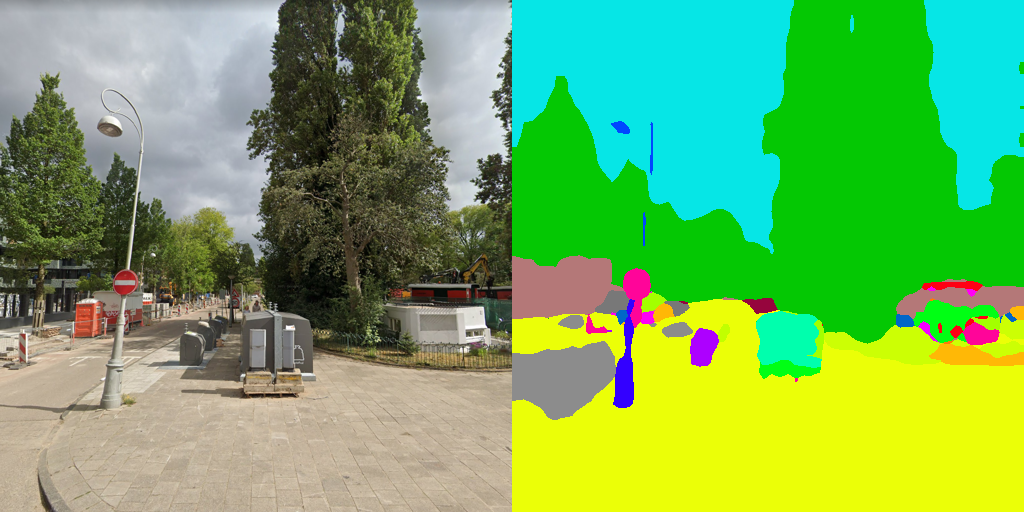

In [36]:
import numpy
# # 可以创建数据加载器
# dataloader = DataLoader(dataset, batch_size=32, max_split_size_mb=500, device='cuda')

# 在最高分辨率下运行分割
# 使用inference_mode()上下文管理器，速度更快，可以在不跟踪梯度的情况下运行模型
with torch.inference_mode():
    # 使用分割模块对单张批次进行分割，输出尺寸为output_size
    scores = segmentation_module(singleton_batch, segSize=output_size)

# 获取每个像素的预测得分
# 使用torch.max()函数获取每个像素位置的最大得分及其对应的类别索引
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()  # 将预测结果转移到CPU上，并转换为NumPy数组

# 将预测结果可视化为彩色图像
pred_color = visualize_result(img_original, pred)

In [32]:
pred

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [20, 20, 20, ..., 12, 12, 12],
       [20, 20, 20, ..., 12, 12, 12],
       [20, 20, 20, ..., 12, 12, 12]], dtype=int64)

In [33]:
pred.shape

(512, 512)

In [28]:
pred_color.shape

(512, 512, 3)

## Showing classes individually

To see which colors are which, here we visualize individual classes, one at a time.

### numpy.bincount
`numpy.bincount(pred.flatten())`是一个用于统计数组中每个元素出现次数的函数。在这里，`pred`是一个二维数组，通过`pred.flatten()`将其展平成一维数组，然后使用`numpy.bincount()`对展平后的数组进行统计。

`numpy.bincount()`返回一个长度为`n`的数组，其中`n`是输入数组中的最大元素加1。数组的索引表示元素的值，数组的值表示该元素在输入数组中出现的次数。

### argsort和[::-1]
接下来，`argsort()`函数对统计结果进行排序，返回按照元素值从小到大排列的索引数组。然而，为了按照出现次数从大到小的顺序进行排序，我们使用`[::-1]`来对索引数组进行逆序排列。


因此，`predicted_classes`将包含按照元素出现次数从大到小排列的类别索引。这意味着`predicted_classes[0]`将是出现次数最多的类别索引，`predicted_classes[1]`将是次多的类别索引，以此类推。

In [37]:
# 计算每个类别的像素数，并获取从多到少的排序
class_counts = np.bincount(pred.flatten())
sorted_classes = class_counts.argsort()[::-1]

count = 1
for c in sorted_classes[:4]: # 只显示第一个
    print(f'排序后（占比多的在前）第{count}个类别名称是：{names[c+1]}，预测的类别代号：{c}')
    count += 1

排序后（占比多的在前）第1个类别名称是：tree，预测的类别代号：4
排序后（占比多的在前）第2个类别名称是：sidewalk，预测的类别代号：11
排序后（占比多的在前）第3个类别名称是：sky，预测的类别代号：2
排序后（占比多的在前）第4个类别名称是：building，预测的类别代号：1


In [25]:
# 检查“建筑物”是否是最常见的类别
building_index = 1
if sorted_classes[0] == building_index:
    building_ratio = class_counts[building_index] / pred.size
    print(f'“建筑物”类别的像素数占比为{building_ratio:.2%}')
    # 如果“建筑物”的比例超过40%，执行相应的操作
    if building_ratio > 0.4:
        # 执行你想要的操作，例如可视化或保存图像
        print("1")
        pass
    else:
        print("2")
        pass

“建筑物”类别的像素数占比为46.30%
1


In [26]:
# 打印前四个最常见的类别
for i, c in enumerate(sorted_classes[:4]):
    print(f'排序后（占比多的在前）第{i+1}个类别名称是：{names[c+1]}，预测的类别代号：{c}')

排序后（占比多的在前）第1个类别名称是：building，预测的类别代号：1
排序后（占比多的在前）第2个类别名称是：car，预测的类别代号：20
排序后（占比多的在前）第3个类别名称是：tree，预测的类别代号：4
排序后（占比多的在前）第4个类别名称是：person，预测的类别代号：12


In [ ]:
##### 新方法

In [18]:
 # 计算图像中的总像素数
total_pixels = pred.size
total_pixels

262144

In [19]:
# 计算图像中“建筑物”类别的像素数
building_index = 2 # 查表可知 object150_info.csv
building_pixels = (pred == building_index).sum()

In [20]:
building_pixels

0

building:


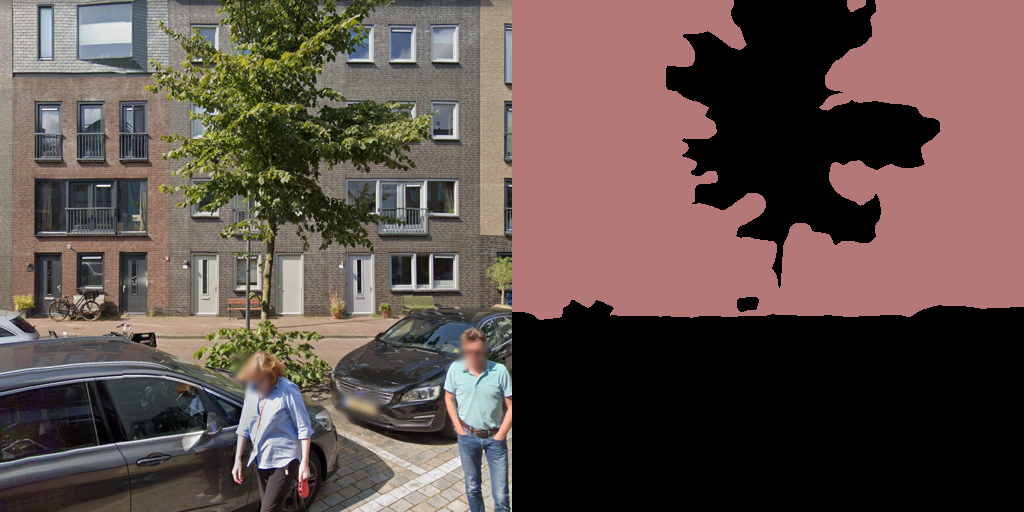

预测结果的大小vs.size： 786432
预测结果vs： [[[180 120 120]
  [180 120 120]
  [180 120 120]
  ...
  [180 120 120]
  [180 120 120]
  [180 120 120]]

 [[180 120 120]
  [180 120 120]
  [180 120 120]
  ...
  [180 120 120]
  [180 120 120]
  [180 120 120]]

 [[180 120 120]
  [180 120 120]
  [180 120 120]
  ...
  [180 120 120]
  [180 120 120]
  [180 120 120]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


In [15]:
# 可视化结果
vs = visualize_result(img_original, pred, c)
print("预测结果的大小vs.size：", vs.size)
print("预测结果vs：", vs)

In [16]:
# 计算占比
total = np.multiply(vs.shape[0] , vs.shape[1])
print(vs.size == total)
print(total)
proportion = np.sum((vs != [0,0,0]).all(axis=2)) # / total
print(proportion)
print(proportion/total)

False
262144
121377
0.4630165100097656


In [ ]:
# ## 计算占比
# 通过数组算出占比 此为方法一 计算速度快一点 但是我要花时间写代码
pred_color.size == 512*512*3


In [ ]:
# 通过数组算出占比 此为方法一 计算速度快一点 但是我要花时间写代码
pred_color.size == 512*512*3
# 这意味着此numpy数组有512行，每行有5125个元素，每个元素有3个值(RGB)。

你可以使用numpy.where()函数，将二维数组中不满足三个值都相等的条件的值设置为0：
arr = np.where((arr[:,0] == arr[:,1]) & (arr[:,1] == arr[:,2]), arr, 0)
然后再计算均值：
mean_val = np.mean(arr)

In [ ]:
pred_color[:,] == np.array([6, 230, 230])

In [ ]:
# 你可以使用numpy.where()函数，将pred_color数组中不满足三个值都等于np.array([6, 230, 230])的条件的值设置为0：
pred_color2 = np.where(pred_color[:,] == np.array([6, 230, 230]), pred_color, 0)
# 然后计算非零元素的占比：
proportion = np.mean(pred_color2 != 0)
print(proportion)

In [ ]:
for arr in [np.array([6, 230, 230])]: # ,np.array([180, 120, 120])
    print(pred_color == arr)
    proportion = np.mean(pred_color == arr)
    print("sky,building的比例分别书",proportion)
    # print(np.sum(~(proportion == arr).all(axis=2)) / np.multiply(proportion.shape[0] , proportion.shape[1]))
    count = np.count_nonzero(pred_color == arr)
    print(count)
    size = np.size(pred_color)
    print(size)